# XGBoost Regression for Flight Fare Prediction

## 1. Import Required Libraries

Import essential Python libraries for XGBoost implementation:
- **xgboost**: Core library for gradient boosting regression and classification
- **optuna**: Bayesian hyperparameter optimization framework
- **scikit-learn**: Cross-validation and performance metrics
- **pandas & numpy**: Data manipulation and numerical operations
- **matplotlib**: Visualization of results and model performance
- **pickle**: Model serialization for saving and deployment

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import optuna
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

/Users/I569765/Documents/GitHub/University/Master 1. Semester/Data-Mining-Project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load and Prepare Dataset

Load the preprocessed training and test datasets from CSV files. These datasets have been prepared in the preprocessing stage and contain flight information with various features.

**Dataset Structure:**
- Training set: Used for model training and hyperparameter optimization
- Test set: Used for final model evaluation and performance assessment
- Target variable: `baseFare` (flight ticket price to predict)
- Features: Flight attributes such as departure/arrival times, airports, airlines, distance, etc.

In [2]:
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

print(train_data.info())

Training data shape: (125668, 50)
Test data shape: (31418, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125668 entries, 0 to 125667
Data columns (total 50 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   elapsedDays                            125668 non-null  int64  
 1   isBasicEconomy                         125668 non-null  int64  
 2   seatsRemaining                         125668 non-null  int64  
 3   Booking Lead Time                      125668 non-null  int64  
 4   departureTime_sin                      125668 non-null  float64
 5   departureTime_cos                      125668 non-null  float64
 6   travelDuration_minutes                 125668 non-null  float64
 7   startingAirport_BOS                    125668 non-null  int64  
 8   startingAirport_CLT                    125668 non-null  int64  
 9   startingAirport_DEN                    125668 non-null  int64 

## 3. Feature Engineering and Data Preparation

Prepare features and target variables for XGBoost training. This step involves:

**Data Splitting:**
- Separate features (X) from target variable (y) for both training and test sets
- Target: `baseFare` - the flight ticket price we want to predict
- Features: All other columns containing flight information

**XGBoost Advantages:**
- Handles mixed data types (numerical and categorical) efficiently
- No manual feature scaling required (tree-based algorithm)
- Built-in handling of missing values. However preprocessing has shown that there are no missing values anyways.

In [3]:
target_column = 'baseFare'

y_train = train_data[target_column]
X_train = train_data.drop(columns=[target_column])

y_test = test_data[target_column]
X_test = test_data.drop(columns=[target_column])

## 4. Optuna Bayesian Optimization

Refine hyperparameters using Bayesian optimization. Optuna explores the hyperparameter space efficiently and can find better values between grid points.

**Hyperparameters Optimized:**
- **n_estimators**: Number of boosting rounds/trees (100-600)
  - More trees generally improve performance but increase computation time
- **max_depth**: Maximum depth of each tree (3-15)
  - Controls model complexity and prevents overfitting
- **learning_rate**: Step size shrinkage to prevent overfitting (0.01-0.3)
  - Lower values require more trees but often generalize better
- **subsample**: Fraction of samples used for each tree (0.6-1.0)
  - Introduces randomness to prevent overfitting
- **colsample_bytree**: Fraction of features used for each tree (0.6-1.0)
  - Reduces correlation between trees
- **reg_alpha**: L1 regularization term (0-1.0)
  - Helps with feature selection
- **reg_lambda**: L2 regularization term (0-2.0)
  - Smooths final learned weights to avoid overfitting

**Optimization Strategy:**
- 5-fold cross-validation for robust performance estimation
- TPE (Tree-structured Parzen Estimator) sampler for intelligent search
- MedianPruner to stop unpromising trials early
- Maximize negative MSE (minimize prediction error)

Objective: 5-fold CV maximizing negative MSE (i.e., better is closer to 0 from below)

In [4]:
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),
        'objective': 'reg:squarederror',
        'random_state': 1,
        'n_jobs': -1,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    return np.mean(scores)

In [5]:
study_xgb = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=0,
        interval_steps=1
    ),
)

study_xgb.optimize(xgb_objective, n_trials=50, timeout=None, show_progress_bar=True)

best_neg_mse = study_xgb.best_value
best_mse = -best_neg_mse
best_rmse = np.sqrt(best_mse)

print("Optuna Best Parameters:")
print(study_xgb.best_params)
print(f"Best CV neg-MSE (maximize): {best_neg_mse:.6f}")
print(f"Best CV MSE: {best_mse:.6f}")
print(f"Best CV RMSE: {best_rmse:.6f}")
print(f"Number of trials: {len(study_xgb.trials)}")
print(f"Pruned trials: {len([t for t in study_xgb.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"Completed trials: {len([t for t in study_xgb.trials if t.state == optuna.trial.TrialState.COMPLETE])}")

Best trial: 42. Best value: -0.03985: 100%|██████████| 50/50 [10:13<00:00, 12.26s/it]  

Optuna Best Parameters:
{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.06551413169675839, 'subsample': 0.9105481667264479, 'colsample_bytree': 0.6599098944164331, 'reg_alpha': 0.06528651722078758, 'reg_lambda': 0.3934947006184668}
Best CV neg-MSE (maximize): -0.039850
Best CV MSE: 0.039850
Best CV RMSE: 0.199625
Number of trials: 50
Pruned trials: 0
Completed trials: 50


Train final model with Optuna-best params:

In [6]:
best_params_xgb = study_xgb.best_params
best_params_xgb['objective'] = 'reg:squarederror'
best_params_xgb['random_state'] = 42
best_params_xgb['n_jobs'] = -1
best_params_xgb['verbosity'] = 0

xgb_regressor = xgb.XGBRegressor(**best_params_xgb)
xgb_regressor.fit(X_train, y_train)

print("Final Optimized Model Configuration (Optuna)")
print(f"  n_estimators: {xgb_regressor.n_estimators}")
print(f"  max_depth: {xgb_regressor.max_depth}")
print(f"  learning_rate: {xgb_regressor.learning_rate}")
print(f"  subsample: {xgb_regressor.subsample}")
print(f"  colsample_bytree: {xgb_regressor.colsample_bytree}")
print(f"  reg_alpha (L1): {xgb_regressor.reg_alpha}")
print(f"  reg_lambda (L2): {xgb_regressor.reg_lambda}")

Final Optimized Model Configuration (Optuna)
  n_estimators: 500
  max_depth: 13
  learning_rate: 0.06551413169675839
  subsample: 0.9105481667264479
  colsample_bytree: 0.6599098944164331
  reg_alpha (L1): 0.06528651722078758
  reg_lambda (L2): 0.3934947006184668


## 5. Predictions with the Optimized Model

Generate predictions on the test dataset using the optimized XGBoost model obtained from Optuna.

**Prediction Process:**
- Use the best estimator with optimal hyperparameters
- Apply model to unseen test data
- Generate continuous price predictions for each flight

**Results Analysis:**
- Create DataFrame comparing predicted vs actual fares
- Calculate absolute and percentage errors for each prediction
- Analyze prediction statistics (range, mean, distribution)

This step evaluates how well the model generalizes to new, unseen flight data.

In [7]:
y_pred_log = xgb_regressor.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

print(f"Number of predictions: {len(y_pred)}")
print(f"Prediction range: ${y_pred.min():.2f} to ${y_pred.max():.2f}")
print(f"Mean prediction: ${y_pred.mean():.2f}")

results_df = pd.DataFrame({'Predicted_baseFare': y_pred})

results_df['Actual_baseFare'] = y_test_original
results_df['Absolute_Error'] = np.abs(y_test_original - y_pred)
results_df['Squared_Error'] = (y_test_original - y_pred) ** 2

mae_preview = results_df['Absolute_Error'].mean()
print(f"  Mean Absolute Error: ${mae_preview:.2f}")

Number of predictions: 31418
Prediction range: $0.38 to $831.71
Mean prediction: $189.01
  Mean Absolute Error: $23.35


## 6. Evaluating Model Performance

Comprehensive evaluation of the XGBoost model using multiple metrics and visualizations to assess prediction quality.

**Performance Metrics:**
- **R-squared Score**: Proportion of variance explained (1.0 = perfect, 0.0 = no better than mean)
- **RMSE** (Root Mean Squared Error): Average prediction error in dollars (penalizes large errors)
- **MAE** (Mean Absolute Error): Average absolute difference between predictions and actuals
- **MSE** (Mean Squared Error): Squared average of errors (more sensitive to outliers)

**Visualizations:**
1. **Performance Metrics Table**: Clean summary of all key metrics
2. **Residuals Plot**: Shows prediction errors across predicted values (random scatter = good model)
3. **Actual vs Predicted Plot**: Scatter plot showing prediction accuracy (points near diagonal = good predictions)
4. **Error Distribution**: Histogram of absolute errors with MAE reference line

**Note on the dashed line:** The red dashed line in the "Actual vs Predicted" plot represents perfect predictions (y = x), where predicted and actual values are identical. Points close to this line indicate high model accuracy.

**Residual Analysis:**
- Examines patterns in prediction errors
- Identifies systematic biases or heteroscedasticity
- Validates model assumptions

**Note on the dashed line:** The gray dashed line in the "Actual vs Predicted" plot represents perfect predictions (y = x), where predicted and actual values are identical. Points close to this line indicate high model accuracy.

Performance metrics on the original scale)
Mean Squared Error (MSE): 2681.9478
Root Mean Squared Error (RMSE): $51.7875
Mean Absolute Error (MAE): $23.3533
R-squared Score (Original Scale): 0.8047
R-squared Score (Log Scale): 0.9191
Mean Actual Value: $193.01
Mean Predicted Value: $189.01


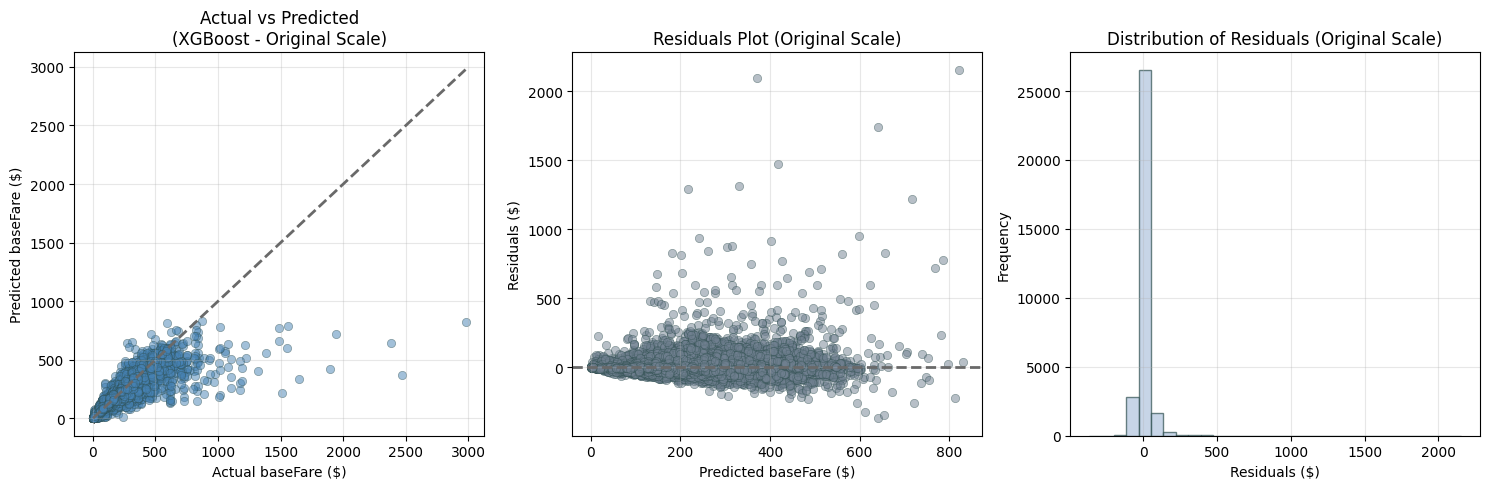

In [8]:
y_pred_log = xgb_regressor.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

r2_log = r2_score(y_test, y_pred_log)

mean_actual = y_test_actual.mean()
mean_predicted = y_pred.mean()

print(f"Performance metrics on the original scale)")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.4f}")
print(f"R-squared Score (Original Scale): {r2:.4f}")
print(f"R-squared Score (Log Scale): {r2_log:.4f}")
print(f"Mean Actual Value: ${mean_actual:.2f}")
print(f"Mean Predicted Value: ${mean_predicted:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_actual, y_pred, alpha=0.5, color='steelblue', edgecolors='darkslategray', linewidth=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
            [y_test_actual.min(), y_test_actual.max()], '--', color='dimgray', lw=2)
plt.xlabel('Actual baseFare ($)')
plt.ylabel('Predicted baseFare ($)')
plt.title('Actual vs Predicted\n(XGBoost - Original Scale)')
plt.grid(True, alpha=0.3)

residuals = y_test_actual - y_pred
plt.subplot(1, 3, 2)
plt.scatter(y_pred, residuals, alpha=0.5, color='slategray', edgecolors='darkslategray', linewidth=0.5)
plt.axhline(y=0, color='dimgray', linestyle='--', lw=2)
plt.xlabel('Predicted baseFare ($)')
plt.ylabel('Residuals ($)')
plt.title('Residuals Plot (Original Scale)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='darkslategray', color='lightsteelblue')
plt.xlabel('Residuals ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Analyze which features contribute most to the XGBoost model's prediction decisions. Feature importance scores indicate how much each feature improves prediction accuracy across all trees.

**Feature Importance Interpretation:**
- **Higher scores**: Features that significantly improve prediction accuracy
- **Lower scores**: Features with minimal impact on predictions
- XGBoost provides multiple importance metrics:
  - **Weight**: Number of times a feature appears in trees
  - **Gain**: Average improvement in accuracy when using the feature
  - **Cover**: Average number of samples affected by splits on the feature

**Analysis Components:**
1. **Horizontal Bar Chart**: Visual comparison of top 20 features
2. **Distribution Histogram**: Shows spread of importance across all features
3. **Cumulative Importance**: Identifies minimum feature set needed for good performance
4. **Top Features Bar Chart**: Quick view of most critical features

**Insights:**
- Identify key pricing factors
- Understand model decision-making process
- Potential for feature selection and dimensionality reduction

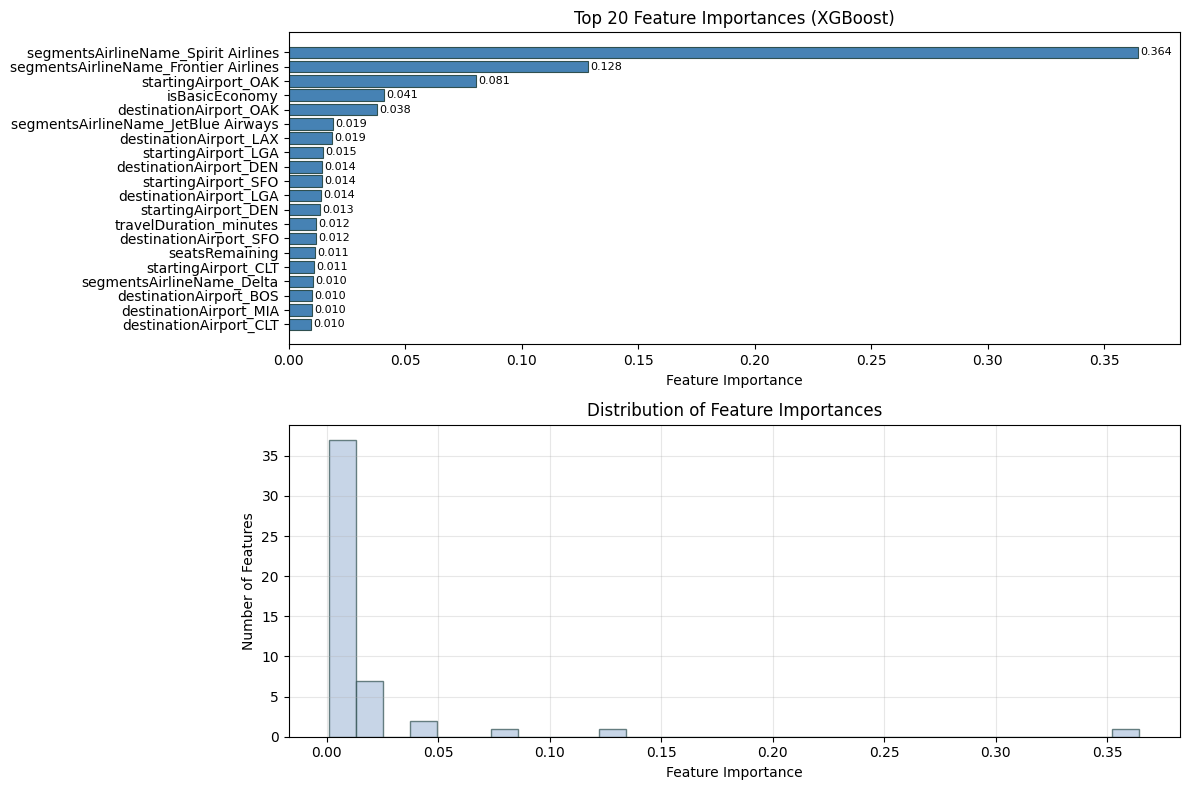

In [9]:
feature_importances = xgb_regressor.feature_importances_
feature_names = xgb_regressor.feature_names_in_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
top_features = importance_df.head(20)
bars = plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='darkslategray', linewidth=0.8)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=8)

plt.subplot(2, 1, 2)
plt.hist(feature_importances, bins=30, alpha=0.7, color='lightsteelblue', edgecolor='darkslategray')
plt.xlabel('Feature Importance')
plt.ylabel('Number of Features')
plt.title('Distribution of Feature Importances')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Error Analysis

Detailed analysis of prediction errors to understand model strengths and weaknesses across different fare ranges.

### Calculate Prediction Errors

Compute absolute and relative errors for detailed analysis.

In [10]:
errors = y_pred - y_test_actual
abs_errors = np.abs(errors)
relative_errors = (abs_errors / y_test_actual) * 100

error_df = pd.DataFrame({
    'actual': y_test_actual,
    'predicted': y_pred,
    'error': errors,
    'abs_error': abs_errors,
    'relative_error_pct': relative_errors
})

### Prediction Range Check

Verify that predictions and actuals are correctly transformed from log scale.

In [11]:
print(f"Actual fares (USD):")
print(f"Min: ${y_test_actual.min():.2f}")
print(f"Max: ${y_test_actual.max():.2f}")
print(f"Mean: ${y_test_actual.mean():.2f}")
print(f"Median: ${np.median(y_test_actual):.2f}")

print(f"\nPredicted fares - XGBoost (USD):")
print(f"Min: ${y_pred.min():.2f}")
print(f"Max: ${y_pred.max():.2f}")
print(f"Mean: ${y_pred.mean():.2f}")
print(f"Median: ${np.median(y_pred):.2f}")

Actual fares (USD):
Min: $1.00
Max: $2976.74
Mean: $193.01
Median: $169.30

Predicted fares - XGBoost (USD):
Min: $0.38
Max: $831.71
Mean: $189.01
Median: $169.31


### Analysis by Fare Range

Investigate how model performance varies across different price ranges.

In [12]:
bins = [0, 100, 200, 300, 500, 1000, 3000]
labels = ['0-100 USD', '100-200 USD', '200-300 USD', '300-500 USD', '500-1000 USD', '1000+ USD']

error_df['fare_range'] = pd.cut(error_df['actual'], bins=bins, labels=labels)

range_analysis = error_df.groupby('fare_range', observed=True).agg({
    'abs_error': ['mean', 'median', 'std'],
    'relative_error_pct': ['mean', 'median'],
    'actual': 'count'
}).round(2)

range_analysis.columns = ['MAE', 'Median_AE', 'Std_AE', 'Mean_Rel_%', 'Median_Rel_%', 'Count']

print("Performance by Fare Range - XGBoost:")
print(range_analysis)

Performance by Fare Range - XGBoost:
                 MAE  Median_AE  Std_AE  Mean_Rel_%  Median_Rel_%  Count
fare_range                                                              
0-100 USD      10.79       6.18   13.12       19.62          9.95   5920
100-200 USD    15.45      10.02   16.52       10.47          6.89  13162
200-300 USD    25.32      18.20   25.15       10.45          7.66   7230
300-500 USD    41.43      26.89   43.68       11.25          7.53   4642
500-1000 USD  142.52     101.47  138.87       22.16         18.07    430
1000+ USD     877.92     793.38  446.51       62.05         60.48     34


### Visualization of Performance by Fare Range

Compare model performance across different price ranges.

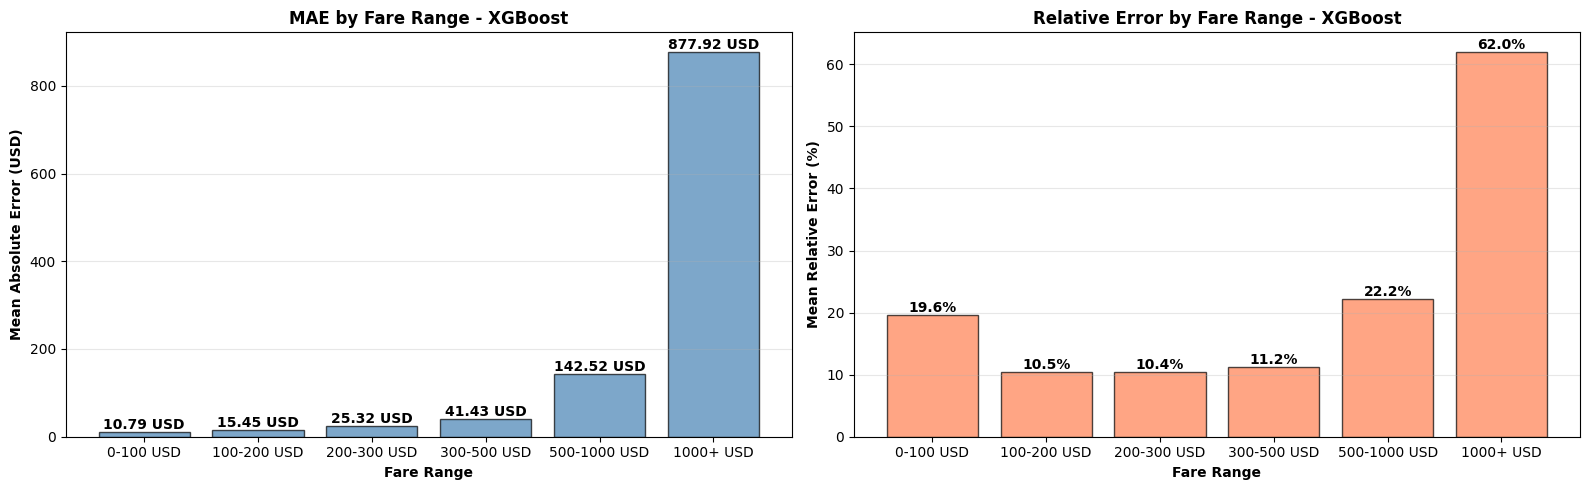

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(range(len(range_analysis)), range_analysis['MAE'], 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(range_analysis)))
axes[0].set_xticklabels(range_analysis.index, rotation=0)
axes[0].set_ylabel('Mean Absolute Error (USD)', fontweight='bold')
axes[0].set_xlabel('Fare Range', fontweight='bold')
axes[0].set_title('MAE by Fare Range - XGBoost', fontweight='bold', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(range_analysis['MAE']):
    axes[0].text(i, v, f'{v:.2f} USD', ha='center', va='bottom', fontweight='bold')

axes[1].bar(range(len(range_analysis)), range_analysis['Mean_Rel_%'], 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(range_analysis)))
axes[1].set_xticklabels(range_analysis.index, rotation=0)
axes[1].set_ylabel('Mean Relative Error (%)', fontweight='bold')
axes[1].set_xlabel('Fare Range', fontweight='bold')
axes[1].set_title('Relative Error by Fare Range - XGBoost', fontweight='bold', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(range_analysis['Mean_Rel_%']):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Worst Predictions Analysis

Identify and analyze the cases where the model performs worst. Top 10 worst results here.

In [14]:
worst_10 = error_df.nlargest(10, 'abs_error')[['error', 'actual', 'predicted', 'abs_error', 'relative_error_pct']]
print("Top 10 Worst Predictions (by Absolute Error):")
print(worst_10)

Top 10 Worst Predictions (by Absolute Error):
             error   actual   predicted    abs_error  relative_error_pct
26233 -2155.461191  2976.74  821.278809  2155.461191           72.410126
774   -2097.583645  2467.91  370.326355  2097.583645           84.994333
17750 -1736.843645  2377.67  640.826355  1736.843645           73.048137
1689  -1474.274303  1893.02  418.745697  1474.274303           77.879489
7432  -1314.658224  1646.51  331.851776  1314.658224           79.845141
23645 -1292.863116  1510.70  217.836884  1292.863116           85.580401
29395 -1221.616541  1938.60  716.983459  1221.616541           63.015400
29864  -950.031826  1547.91  597.878174   950.031826           61.375133
3311   -932.909440  1174.89  241.980560   932.909440           79.403982
3316   -915.706010  1318.14  402.433990   915.706010           69.469556


## 9. Save Trained Model

Save the XGBoost model to the `models` directory for future use.

In [15]:
model_path = 'models/xgboost_regressor.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(xgb_regressor, f)

print(f"Model saved successfully to: {model_path}")

Model saved successfully to: models/xgboost_regressor.pkl
